<a href="https://colab.research.google.com/github/Abhishek3102/Reinforcement-Learning/blob/main/Cartpole_using_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gymnasium[classic_control]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 13.7 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple,deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
  from IPython import display
plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

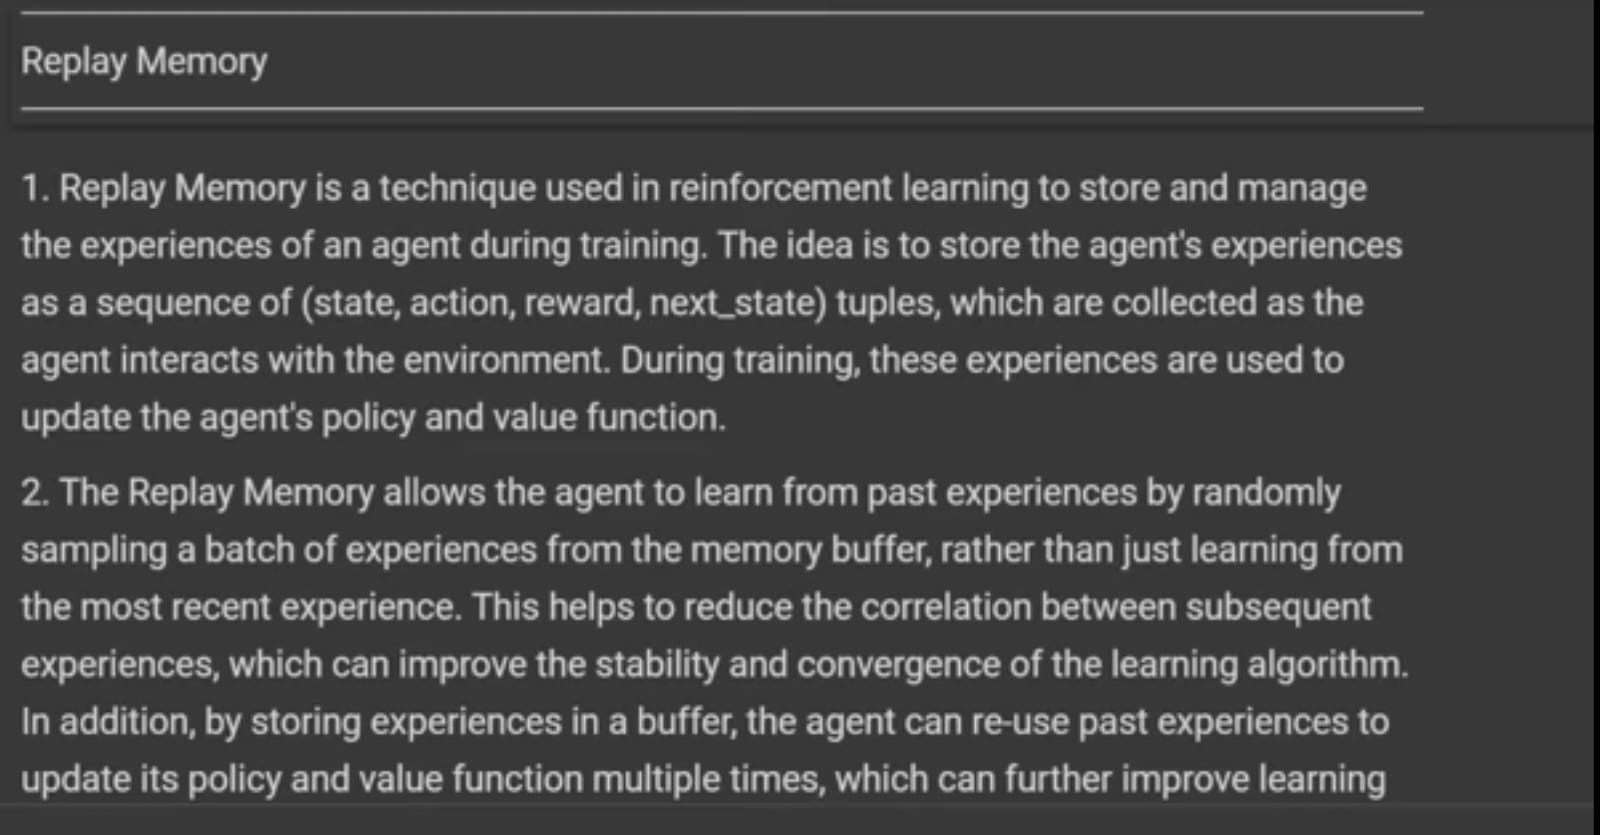

In [3]:
Transition = namedtuple('Transition',('state','action','next_state','reward'))

class ReplayMemory(object):
  def __init__(self,capacity):
    self.memory = deque([], maxlen=capacity)

    def push(self, *args):
      self.memory.append(Transition(*args))
      """Save a transition"""

      def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

In [4]:
class DQN(nn.Module):
  """Multi-layer perceptron with three layers."""
  """n_observations is input(state of the environment) to the network"""
  """n_actions is the output(no. of possible actions) in the environment"""
  def __init__(self, n_observations, n_actions):
    super(DQN, self).__init__()
    self.layer1 = nn.Linear(n_observations, 128)
    self.layer2 = nn.Linear(128, 128)
    self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
      x = F.relu(self.layer1(x))
      x = F.relu(self.layer2(x))
      return self.layer3(x)

In [5]:
"""Batch size is the number of transitions sampled from the replay buffer."""
BATCH_SIZE = 128

GAMMA = 0.99 # discount factor
EPS_START = 0.9 # starting value of epsilon
EPS_END = 0.05  # final value of epsilon
EPS_DECAY = 1000 # exponential decay rate for epsilon
TAU = 0.005 # update rate of target network
LR = 1e-4

In [ ]:
# get the number of actions from gym action space
n_actions = env.action_space.n

# get the number of state observations
state,info = env.reset()


n_observations = len(state)

"""target_net is initialized with same weights as policy_net"""
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
"""Memory will store the agent's experiences, which will be used for training"""
memory = ReplayMemory(10000)

"""keep track of steps taken by agent"""
steps_done = 0

def select_action(state):
  global steps_done
  sample = random.random()
  eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
  steps_done += 1
  if sample > eps_threshold:
    with torch.no_grad():
      return policy_net(state).max(1)[1].view(1,1)
  else:
    return torch.tensor([[env.action_space.sample()]], dtype=torch.long)
# used to keep track of duration of each episode
episode_durations = []

def plot_duration(show_result=False):
  plt.figure(1)
  duration_t = torch.tensor(episode_durations, dtype=torch.float)
  if show_result:
    plt.title('Result')
  else:
    plt.clf()
    plt.title('Training...')
  plt.xlabel('Episode')
  plt.ylabel('Duration')
  plt.plot(durations_t.numpy())

  if (len(durations_t) >= 100):

